In [1]:
%run -i billiard_defs.py

### Parameters
NP = np.arange(1,2) * sqrt_threads_per_block_max
modes = ['serial', 'parallel']
modes = ['parallel']
run_time = {key:[] for key in modes}
pos = {key:[] for key in modes}

for num_part in NP:
    for mode in modes:
        start = timer()
        seed = 10
        rnd = np.random.RandomState(seed)

        dim = 2
        side = 10
        
        ## compute radius so that particles take up a fixed proportion of the volume of the box
        density = 0.1
        V_box = side**dim
        V_part_box = density * V_box / num_part  # volume of little box each particle must fit into
        radius = (V_part_box)**(1/dim) / 2
        mass = 4

        max_steps = 100
        max_records = None
        try:
            rec_period = int(np.ceil(max_steps / max_records))
        except:
            rec_period = 1
        if (rec_period < 1) or (rec_period is np.inf):
            rec_period = 1

        wall = []
        for d in range(dim):
            for s in [-1,1]:
                v = np.zeros(dim, dtype=np_dtype)
                v[d] = s*side
                wall.append(FlatWall(base_point=v.copy(), normal=-v.copy()))

        part = Particles()

        # set any initial positions and velocities here
        
        part.initialize()

#         e = np.full(dim, np.inf)
#         for p in range(num_part):
#             if 
#             if p <= part.pos.shape[0]:
#                 part.pos = np.vstack([part.pos, e.copy()])
#                 part.rand_pos(p)

#             if p <= part.vel.shape[0]:
#                 part.vel = np.vstack([part.vel, e.copy()])
#                 part.rand_vel(p)


        part.KE_init = part.get_KE()
        part.check()
        part.record_state()

        if mode == 'parallel':
            %run -i gpu_defs.py
            #exec(open("gpu_defs.py").read())
            load_gpu(part)

        def get_col_time(part):
            part.get_pw_col_time_cpu()

            if mode == 'parallel':
                get_pp_col_time_gpu(part)
            else:
                part.get_pp_col_time_cpu()

            part.dt = min([np.min(part.pp_dt), np.min(part.pw_dt)])
            return part.dt
        
        for step in range(max_steps):
            next_state(part)
            if mode == 'parallel':
                update_gpu(part)
        #         disp_gpu(part.pos_smrt)
                check_sync()
                part.check()

            if step % rec_period == 0:        
                print('num_part = {}, step = {}'.format(part.num,step))
                part.record_state()
                part.check()
                
        part.clean_up()
        elapsed = timer() - start
        print('Done!! #Particles = {}, Steps = {}, Sim Time = {:2f}, Elapsed Time = {:2f}'.format(part.num, len(part.t_hist)-1, part.t_hist[-1], elapsed))
        run_time[mode].append(elapsed)
        pos[mode].append(part.pos_hist.copy())
#     print(pos['serial'][-1] - pos['parallel'][-1])
#     assert np.allclose(pos['serial'][-1], pos['parallel'][-1])

load_gpu
num_part = 32, step = 0
num_part = 32, step = 1
num_part = 32, step = 2
num_part = 32, step = 3
num_part = 32, step = 4
num_part = 32, step = 5
num_part = 32, step = 6
num_part = 32, step = 7
num_part = 32, step = 8
num_part = 32, step = 9
num_part = 32, step = 10
num_part = 32, step = 11
num_part = 32, step = 12
num_part = 32, step = 13
num_part = 32, step = 14
num_part = 32, step = 15
num_part = 32, step = 16
num_part = 32, step = 17
num_part = 32, step = 18
num_part = 32, step = 19
num_part = 32, step = 20
num_part = 32, step = 21
num_part = 32, step = 22
num_part = 32, step = 23
num_part = 32, step = 24
num_part = 32, step = 25
num_part = 32, step = 26
num_part = 32, step = 27
num_part = 32, step = 28
num_part = 32, step = 29
num_part = 32, step = 30
num_part = 32, step = 31
num_part = 32, step = 32
num_part = 32, step = 33
num_part = 32, step = 34
num_part = 32, step = 35
num_part = 32, step = 36
num_part = 32, step = 37
num_part = 32, step = 38
num_part = 32, step = 39
n

In [4]:
if dim != 2:
    raise Exception('only works in 2D')
    
num_steps = len(part.t_hist)

mesh = np.linspace(0,2*np.pi,100)
circle = [np.cos(mesh), np.sin(mesh)]
circle = radius * np.array(circle)
def draw(s=0):
    s %= num_steps
    fig, ax = plt.subplots(figsize=[8,8]);
    ax.plot([side,-side,-side,side,side], [side,side,-side,-side,side], color='black')    
    for p in range(part.num):
        ax.plot(part.pos_hist[:s+1,p,0], part.pos_hist[:s+1,p,1], color=part.clr[p])
        center = part.pos_hist[s,p]
        bdy = circle + center[:,np.newaxis]
        ax.plot(*bdy, color=part.clr[p])
    ax.set_aspect('equal')
    

l = widgets.Layout(width='150px')
step_text = widgets.BoundedIntText(min=0, max=num_steps-1, value=0, layout=l)
step_slider = widgets.IntSlider(min=0, max=num_steps-1, value=0, readout=False, continuous_update=False, layout=l)
play_button = widgets.Play(min=0, max=num_steps-1, step=1, interval=50, layout=l)

widgets.jslink((step_text, 'value'), (step_slider, 'value'))
widgets.jslink((step_text, 'value'), (play_button, 'value'))

img = widgets.interactive_output(draw, {'s':step_text})
display(widgets.HBox([widgets.VBox([step_text, step_slider, play_button]), img]))


HBox(children=(VBox(children=(BoundedIntText(value=0, layout=Layout(width='150px')), IntSlider(value=0, continuous_update=False, layout=Layout(width='150px'), readout=False), Play(value=0, interval=50, layout=Layout(width='150px')))), Output()))

In [3]:
print(np.allclose(part.pp_dt, part.pp_dt_gpu, rtol=1e-3))
np.set_printoptions(precision=8, suppress=False)
d = (part.pp_dt- part.pp_dt_gpu)#/part.pp_dt
np.nanmax(np.abs(d))
# d[14]
# part.pp_dt[14]
# part.pp_dt_gpu[14]
part.pp_dt
d

False


gpu_defs.py:3: RuntimeWarning: invalid value encountered in subtract
  import numba.cuda as cuda


array([ 5.96046448e-08,  1.19209290e-06,  7.15255737e-07,  1.90734863e-06,
       -2.19345093e-05, -1.90734863e-05,  7.15255737e-07, -3.57627869e-07,
        9.53674316e-07,  3.57627869e-07,             nan, -5.96046448e-08,
        3.05175781e-05,  0.00000000e+00,             inf,  5.72204590e-06,
        0.00000000e+00, -1.19209290e-07,             nan,  3.33786011e-06,
        7.15255737e-07,             nan, -4.76837158e-07, -5.96046448e-07,
       -5.96046448e-08,  9.53674316e-07,  3.57627869e-07, -2.38418579e-07,
       -1.49011612e-08,             nan,             nan, -2.38418579e-07,
       -6.43730164e-06,             nan,             nan,  1.85966492e-05,
       -4.76837158e-07,  1.43051147e-06,  5.96046448e-08,  1.43051147e-06,
       -2.38418579e-07, -2.38418579e-07,             nan,             nan,
                   nan, -1.19209290e-06, -1.43051147e-05,  0.00000000e+00,
        4.29153442e-06,  1.90734863e-06, -1.95503235e-05, -1.49011612e-08,
                   nan, -

In [14]:
idx = np.isinf(part.pp_dt_gpu)
print(part.pp_dt_gpu)
print(part.pp_dt)
d = part.pp_dt_gpu-part.pp_dt
print(d[~idx])
print(part.pp_dt_gpu[idx])
print(part.pp_dt[idx])

[ 5.58  1.42  2.58  1.72   inf  0.02  2.     inf  6.83   inf  4.16   inf
   inf   inf  1.72  0.89   inf   inf  0.05 10.16  0.05 10.6   2.    6.83
   inf  4.21  1.42 13.42  4.43  0.02  4.43  0.89]
[ 5.58  1.42  2.58  1.72   inf  0.02  2.     inf  6.83   inf  4.16   inf
   inf   inf  1.72  0.89   inf   inf  0.05 10.16  0.05 10.6   2.    6.83
   inf  4.21  1.42 13.42  4.43  0.02  4.43  0.89]
[ 0. -0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0.  0. -0. -0.  0.  0. -0.
  0.  0. -0.  0.  0.]
[inf inf inf inf inf inf inf inf inf]
[inf inf inf inf inf inf inf inf inf]


gpu_defs.py:4: RuntimeWarning: invalid value encountered in subtract
  nb_dtype = nb.float32


In [12]:
check_sync(part)
c = part.pos
s = part.pos_smrt
# print(s.get('host')-c)
print(s.get('gpu')-c)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


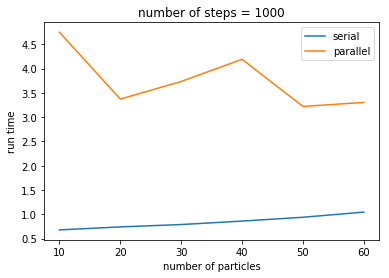

In [7]:
w = min([len(t) for k,t in run_time.items()])
for mode, time in run_time.items():
    plt.plot(NP[:w], run_time[mode][:w], label=mode)
plt.legend()
plt.xlabel('number of particles')
plt.ylabel('run time')
plt.title('number of steps = {}'.format(max_steps))
plt.show()

In [5]:
update_gpu(part)
A = part.pp_dt_block_smrt
# print(A.get('gpu').copy_to_host())
def f1():
    return A.get('gpu').copy_to_host().min(axis=1)

def f2():
    return A.min(axis=1)

def f3():
    return cuda.np.min(A,axis=1)

print(np.allclose(f1(),f2()))
print(np.allclose(f1(),f3()))
%timeit f1()
%timeit f2()
%timeit f3()

False
False
109 µs ± 10 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
4.3 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.84 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [16]:
# disp_gpu(part.pp_dt_block_smrt)
# part.pp_dt_block_smrt.mark_changed('gpu')
help(part.pp_dt_block_smrt.mark_changed)
# print(part.pp_dt_block_smrt.get('gpu').copy_to_host())
# print(part.pp_dt_block_smrt.get('host'))
cuda.synchronize()
print(part.pp_dt_block_smrt.min(axis=1))
print(cuda.np.min(part.pp_dt_block_smrt,axis=1))
print(part.pp_dt_block_smrt.get('gpu').copy_to_host().min(axis=1))

Help on method mark_changed in module numba.smartarray:

mark_changed(where='host') method of numba.smartarray.SmartArray instance
    Mark the given location as changed, broadcast updates if needed.

[inf inf inf inf]
[inf inf inf inf]
[inf inf inf inf]


In [20]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import numba as nb
import numba.cuda as cuda


A = np.random.rand(3,4)
A_smrt = nb.SmartArray(A)
A = A_smrt.get('host')
A[1,1]=12345
# A_smrt[1,1]=12345
print(A)
print(A_smrt.get('host'))
print(A_smrt.get('gpu').copy_to_host())
print(A*3)
A*=300
print(A_smrt.get('host'))
print(A_smrt.get('gpu').copy_to_host())
A_smrt.mark_changed()
print(A_smrt.get('gpu').copy_to_host())

[[    0.57     0.34     0.6      0.69]
 [    0.93 12345.       0.28     0.79]
 [    0.83     0.03     0.56     0.2 ]]
[[    0.57     0.34     0.6      0.69]
 [    0.93 12345.       0.28     0.79]
 [    0.83     0.03     0.56     0.2 ]]
[[    0.57     0.34     0.6      0.69]
 [    0.93 12345.       0.28     0.79]
 [    0.83     0.03     0.56     0.2 ]]
[[    1.72     1.02     1.8      2.06]
 [    2.79 37035.       0.84     2.38]
 [    2.48     0.1      1.68     0.6 ]]
[[    172.4      102.2      180.05     206.09]
 [    279.04 3703500.        83.56     238.29]
 [    248.36       9.59     168.5       60.32]]
[[    0.57     0.34     0.6      0.69]
 [    0.93 12345.       0.28     0.79]
 [    0.83     0.03     0.56     0.2 ]]
[[    172.4      102.2      180.05     206.09]
 [    279.04 3703500.        83.56     238.29]
 [    248.36       9.59     168.5       60.32]]


In [11]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import numba as nb
import numba.cuda as cuda


A = np.random.rand(3,4)
A_smrt = nb.SmartArray(A)
A = A_smrt.get('host')
print(A.get('host'))
A[1,1]=1234

# print(A.get('host'))
print(A.get('gpu').copy_to_host())
# A.mark_changed()
# print(A.get('gpu').copy_to_host())
B = A.get('host')
B*3
B[1,2] =456
print(A.get('host'))
print(A.get('gpu').copy_to_host())
A.mark_changed()
print(A.get('gpu').copy_to_host())


[[0.35 0.94 0.35 0.3 ]
 [0.   0.75 0.64 0.18]
 [0.04 0.29 0.58 0.72]]
[[   0.35    0.94    0.35    0.3 ]
 [   0.   1234.      0.64    0.18]
 [   0.04    0.29    0.58    0.72]]
[[   0.35    0.94    0.35    0.3 ]
 [   0.   1234.    456.      0.18]
 [   0.04    0.29    0.58    0.72]]
[[   0.35    0.94    0.35    0.3 ]
 [   0.   1234.      0.64    0.18]
 [   0.04    0.29    0.58    0.72]]
[[   0.35    0.94    0.35    0.3 ]
 [   0.   1234.    456.      0.18]
 [   0.04    0.29    0.58    0.72]]


In [24]:
type(A.get('host'))
type(A.get('gpu').to_host())

ValueError: no associated writeback array

In [31]:
import numba as nb
import numba.cuda as cuda

A = np.random.rand(3,4)
A
A = nb.SmartArray(A)
A
A?

[[-5.53 -5.33 -2.37]
 [ 0.06  4.13 -7.  ]
 [ 4.84 -2.67  4.4 ]
 [-4.44  2.43  4.63]]
host
[[-5.53 -5.33 -2.37]
 [ 0.06  4.13 -7.  ]
 [ 4.84 -2.67  4.4 ]
 [-4.44  2.43  4.63]]
device
[[-5.53 -5.33 -2.37]
 [ 0.06  4.13 -7.  ]
 [ 4.84 -2.67  4.4 ]
 [-4.44  2.43  4.63]]


In [3]:
part.t_hist.shape

(101,)

In [16]:
part.pos_hist[5,2]+circle

ValueError: operands could not be broadcast together with shapes (2,) (2,100) 

In [24]:
A = np.zeros([100,5])
A[15,2] = 1.0
counts = contract(A)

def f1():
    z = np.nonzero(A)
    p,w = z[0][0], z[1][0]
#     return p,w
    
def f2():
    p = np.argmax(counts)
    w = np.argmax(A[p])
#     return p,w

print(f1(),f2())
%timeit f1()
%timeit f2()

None None
5.51 µs ± 95.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.9 µs ± 38.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
part.pw_gap
# part.pos
w = wall[1]
w.base_point, w.normal_static
dx = part.pos - w.base_point
dx.dot(w.normal_static)
w.normal_static
dx
part.pos

array([[ 2.61409942, -7.98069235, -3.64528625]])

In [27]:
A = np.random.rand(3,4,5)
A.shape
np.sum(A,axis=[1,2])

TypeError: 'list' object cannot be interpreted as an integer

In [24]:
part.pw_dt.shape
# part.pos

(4, 3, 2)

In [27]:
z = part.get_pw_gap()
# z=np.rollaxis(z,-1,0)
# z.reshape([:,-1])
z.shape
# z

(40, 6)

In [20]:
np.reshape?

In [3]:
part.vel

array([[-0.01002595,  1.67080819, -0.66437971],
       [-0.60555494,  0.26551159,  0.10854853],
       [ 1.49057364,  0.75636693,  0.46964093],
       [-0.23396259,  1.484537  , -1.07980489],
       [ 2.18032831,  0.19046688,  1.2616859 ],
       [ 0.41765968, -0.26731719, -0.54930901],
       [ 0.80705192,  2.14180538, -0.49561818],
       [ 0.52563742,  0.66023155, -0.35087189],
       [-0.34971048, -1.05272652,  1.28227668],
       [-0.17180538,  2.39470366,  0.91745894],
       [-1.06828657, -1.22769205, -1.79857302],
       [-0.68520734,  0.31935642,  0.4609029 ],
       [ 2.52330509,  0.3473178 , -0.88735951],
       [-1.05961725,  1.98508459,  1.74481415],
       [ 0.43295951, -0.00449346, -1.86472139],
       [-0.60772586, -0.06191203, -0.75389296],
       [-0.10197468, -0.31608082, -1.7764482 ],
       [ 0.56051783, -0.14436676, -0.40013835],
       [-1.2396806 , -0.59347881, -0.43817284],
       [ 0.28143276, -0.31282876, -0.34888192],
       [-1.52114107,  0.23610191,  0.697

In [35]:
def rand_pos(pos):
    z = rnd.uniform(-side, side, size=[1,dim])
    return np.vstack([pos,z])
    
pos = np.empty([0,dim])
for p in range(num_part):
    pos = rand_pos(pos)


In [20]:
y = np.empty([0,3])
x = np.arange(3)
y = np.vstack([y,x])
y = np.vstack([y,x])
y.shape
y

(0,)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [4]:
pos

array([], shape=(0, 2), dtype=float64)